In [1]:
year=2019
month=8

In [2]:
import pandas as pd
import sys
sys.path.append('../../py')
import db
import weighted
import inspect
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import scipy.stats as stats
import numpy as np
import math


In [3]:
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下

In [25]:
conn=db.get_conn()
cities = "('北京','上海','深圳','杭州','广州','南京','成都','东莞','西安','武汉','天津','长沙','宁波','福州','大连','重庆','青岛','济南','合肥','长春','昆明','郑州','沈阳','哈尔滨')"
data_original=pd.read_sql(sql=f"select * from _{year}{month:02} where monthly_salary>0 and monthly_salary<80000 and city in {cities}", con=conn)
conn.close()

In [26]:
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

In [27]:
del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']

In [28]:
#Common Functions
def get_sub_stats_by_col(data, col):
    categories=data[col].unique()
    salary_mean=[]
    salary_95_min=[]
    salary_95_max=[]
    salary_median=[]

    count=[]
    
    categorys_out=[]
    for category in categories:
        #print(feature)
        idata=data[data[col]==category]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(np.average(values, weights=weights))
        

        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_95_min.append(q[0])
        salary_median.append(q[1])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        categorys_out.append(category)
    sub_data=pd.DataFrame()
    sub_data[col]=[c for c in categorys_out]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_95_min']=salary_95_min
    sub_data['salary_median']=salary_median
    sub_data['salary_95_max']=salary_95_max
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data

data_format={"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}","salary_95_min":"{:.0f}","salary_95_max":"{:.0f}"}

translate_dict={}


# 程序员工资

In [29]:
data_city=get_sub_stats_by_col(data,'city')
data_city.style.format(data_format)

,city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
1,北京,17614,3750,15000,45000,27778,10.45%
2,上海,16517,5250,15000,37500,47840,18.01%
9,深圳,16198,5250,14500,37500,39500,14.87%
3,杭州,15106,3500,12500,35000,14206,5.35%
4,广州,13529,3750,12500,30918,29999,11.29%
8,南京,13489,4000,12500,29166,15265,5.75%
6,成都,12161,3500,11500,30578,11946,4.50%
15,东莞,11704,3750,11500,24137,2969,1.12%
0,武汉,11397,3750,10500,25000,15439,5.81%
14,长沙,11164,3750,10500,22916,6503,2.45%


In [30]:
def describe(data_city, career):
    
    for index, row in data_city.iterrows():
        print(f"{year}年{month}月{row[0]}招收{career}{row[5]}人。{year}年{month}月{row[0]}{career}平均工资{row[1]:.0f}元，工资中位数{row[3]:.0f}元，其中95%的人的工资介于{row[2]:.0f}元到{row[4]:.0f}元。\r\n")


In [31]:
describe(data_city,'程序员')

2019年8月北京招收程序员27778人。2019年8月北京程序员平均工资17614元，工资中位数15000元，其中95%的人的工资介于3750元到45000元。

2019年8月上海招收程序员47840人。2019年8月上海程序员平均工资16517元，工资中位数15000元，其中95%的人的工资介于5250元到37500元。

2019年8月深圳招收程序员39500人。2019年8月深圳程序员平均工资16198元，工资中位数14500元，其中95%的人的工资介于5250元到37500元。

2019年8月杭州招收程序员14206人。2019年8月杭州程序员平均工资15106元，工资中位数12500元，其中95%的人的工资介于3500元到35000元。

2019年8月广州招收程序员29999人。2019年8月广州程序员平均工资13529元，工资中位数12500元，其中95%的人的工资介于3750元到30918元。

2019年8月南京招收程序员15265人。2019年8月南京程序员平均工资13489元，工资中位数12500元，其中95%的人的工资介于4000元到29166元。

2019年8月成都招收程序员11946人。2019年8月成都程序员平均工资12161元，工资中位数11500元，其中95%的人的工资介于3500元到30578元。

2019年8月东莞招收程序员2969人。2019年8月东莞程序员平均工资11704元，工资中位数11500元，其中95%的人的工资介于3750元到24137元。

2019年8月武汉招收程序员15439人。2019年8月武汉程序员平均工资11397元，工资中位数10500元，其中95%的人的工资介于3750元到25000元。

2019年8月长沙招收程序员6503人。2019年8月长沙程序员平均工资11164元，工资中位数10500元，其中95%的人的工资介于3750元到22916元。

2019年8月西安招收程序员7575人。2019年8月西安程序员平均工资10918元，工资中位数10499元，其中95%的人的工资介于3750元到22500元。

2019年8月天津招收程序员2447人。2019年8月天津程序员平均工资10776元，工资中位数9500元，其中95%的人的工资介于3750元到22500元。

2019年8月宁波

In [32]:
data_location = pd.read_csv('../city_locations.csv')
data_location=data_location.set_index('city')

In [33]:
from mpl_toolkits.basemap import Basemap

In [34]:
def draw_map(data_city,headcount_scale, title):


    #cities = []
    scale = 5

    locations = [(116.407526, 39.90403),(120, 30)]
    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.figsize'] = [13, 13]
    #plt.figure(figsize = (10,5))
    fig, ax = plt.subplots()
    fig.title=title
    fig.figsize=(10,5)
    fig.dpi=80
    cn_map= Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, \
               projection='lcc', lat_1=33, lat_2=45, lon_0=100) # ‘lcc'将投影方式设置为兰伯特投影

    # load the shapefile, use the name 'states'
    cn_map.readshapefile(r'D:/data/basemap/gadm36_CHN_shp/gadm36_CHN_1', name='china', drawbounds=True, color='gray')
    cn_map.readshapefile(r'D:/data/basemap/gadm36_TWN_shp/gadm36_TWN_1', name='taiwan', drawbounds=True, color='gray')
    #geolocator = Nominatim(user_agent="my-application")



    salary_min=data_city.salary_mean.min()
    salary_max=data_city.salary_mean.max()
    salary_middle = (salary_min+salary_max)/2
    salary_scale=salary_max-salary_min

    for index, row in data_city.iterrows():
        city=row[0]
        
        longitude = data_location.loc[city,'longitude']
        latitude = data_location.loc[city,'latitude']
        salary=row[1]
        headcount=row[5]
        #color
        color_red=0
        color_green=0
        color_blue=0
        if salary>salary_middle:
            color_red = 255 #int((salary - salary_middle) / (salary_scale/2)*255)
            color_green = int((salary_max - salary) / (salary_scale/2)*255)
        else:
            color_blue = int((salary_middle - salary) / (salary_scale/2)*255)
            color_green = int((salary - salary_min) / (salary_scale/2)*255)
            color_red = int((salary - salary_min) / (salary_scale/2)*255)

        color = '#{:02x}{:02x}{:02x}'.format(color_red,color_green,color_blue)


        x, y = cn_map(longitude,latitude)
        cn_map.plot(x,y,marker='o',color=color,markersize=int(math.sqrt(headcount/headcount_scale))+8)
        #ax.annotate(city, (x,y), xytext=(5, 5), textcoords='offset points', fontsize=15)
        #"{}{:.0f}".format(city_cn, salary)
        #ax.text(x+5, y+5,city , fontweight='bold', fontsize=int(headcount/2500+12))
        fontsize=int(math.sqrt(headcount/headcount_scale))+13
        if city == '杭州':
            x=x-400000
            y=y+10000
        elif city=='广州':
            x=x-400000
            y=y+10000
        elif city=='合肥':
            x=x-300000
            y=y+10000
        elif city=='深圳':
            y=y-100000
        elif city=='南京':
            x=x-100000
        elif city=='天津':
            y=y-50000
        elif city=='上海':
            x=x+50000
        elif city=='武汉':
            y=y-50000

        ax.text(x, y, "{}{:.0f}k".format(city, np.round(salary/1000)), fontweight='bold', fontsize=fontsize, bbox={'facecolor':color, 'alpha':0.3, 'pad':0})
    ax.text(2053805, 1077845, "https://github.com/juwikuang/china_job_survey".format(city, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(205805, 107845, "https://github.com/juwikuang/china_job_survey".format(city, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(805805, 4007845, title.format(city, np.round(salary/1000)), fontweight='bold',color='#111111', fontsize=25)    
    ax.text(805805, 3807845, "（城市大小代表招聘数量，颜色代表工资，红色最高，黄色次之，蓝最少）", fontweight='bold',color='#111111', fontsize=13)    
    #cn_map.drawcoastlines() #绘制海岸线
    #cn_map.drawcountries(linewidth=1.5) #绘制国家边界线
    plt.show()


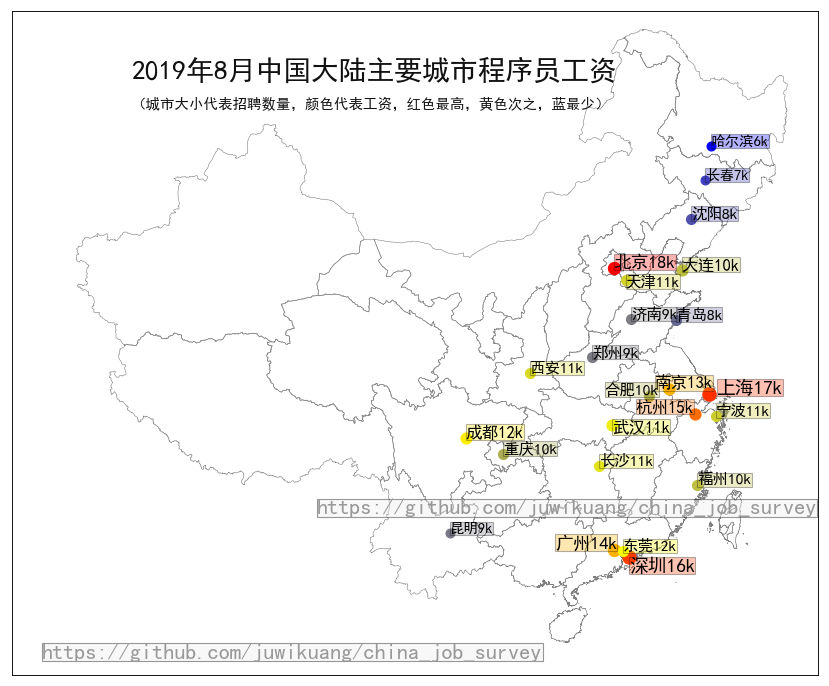

In [35]:
draw_map(data_city,2000,f'{year}年{month}月中国大陆主要城市程序员工资')

# 算法工程师

In [36]:
data_city_algorithm=get_sub_stats_by_col(data[data.career=='算法工程师'],'city')
data_city_algorithm.style.format(data_format)

,city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
0,北京,26105,5270,22500,65000,3471,15.54%
1,上海,23214,5931,22500,50000,4605,20.62%
6,深圳,21826,6500,20000,45000,3517,15.75%
4,杭州,19786,3750,17500,45833,1606,7.19%
3,广州,18934,3781,17500,45000,2185,9.78%
11,南京,18205,7238,17500,35000,1374,6.15%
16,宁波,16560,2667,14583,35000,123,0.55%
10,成都,15411,3848,14000,31250,1034,4.63%
19,合肥,15203,2936,13688,37000,328,1.47%
12,武汉,14988,3750,15000,27500,1278,5.72%


In [37]:
describe(data_city_algorithm,'算法工程师')

2019年8月北京招收算法工程师3471人。2019年8月北京算法工程师平均工资26105元，工资中位数22500元，其中95%的人的工资介于5270元到65000元。

2019年8月上海招收算法工程师4605人。2019年8月上海算法工程师平均工资23214元，工资中位数22500元，其中95%的人的工资介于5931元到50000元。

2019年8月深圳招收算法工程师3517人。2019年8月深圳算法工程师平均工资21826元，工资中位数20000元，其中95%的人的工资介于6500元到45000元。

2019年8月杭州招收算法工程师1606人。2019年8月杭州算法工程师平均工资19786元，工资中位数17500元，其中95%的人的工资介于3750元到45833元。

2019年8月广州招收算法工程师2185人。2019年8月广州算法工程师平均工资18934元，工资中位数17500元，其中95%的人的工资介于3781元到45000元。

2019年8月南京招收算法工程师1374人。2019年8月南京算法工程师平均工资18205元，工资中位数17500元，其中95%的人的工资介于7238元到35000元。

2019年8月宁波招收算法工程师123人。2019年8月宁波算法工程师平均工资16560元，工资中位数14583元，其中95%的人的工资介于2667元到35000元。

2019年8月成都招收算法工程师1034人。2019年8月成都算法工程师平均工资15411元，工资中位数14000元，其中95%的人的工资介于3848元到31250元。

2019年8月合肥招收算法工程师328人。2019年8月合肥算法工程师平均工资15203元，工资中位数13688元，其中95%的人的工资介于2936元到37000元。

2019年8月武汉招收算法工程师1278人。2019年8月武汉算法工程师平均工资14988元，工资中位数15000元，其中95%的人的工资介于3750元到27500元。

2019年8月长沙招收算法工程师392人。2019年8月长沙算法工程师平均工资14743元，工资中位数12500元，其中95%的人的工资介于7000元到31750元。

2019年8月西安招收算法工程师626人。2019年8月西安算法工程师平均工资14053元，工资中位数12916元

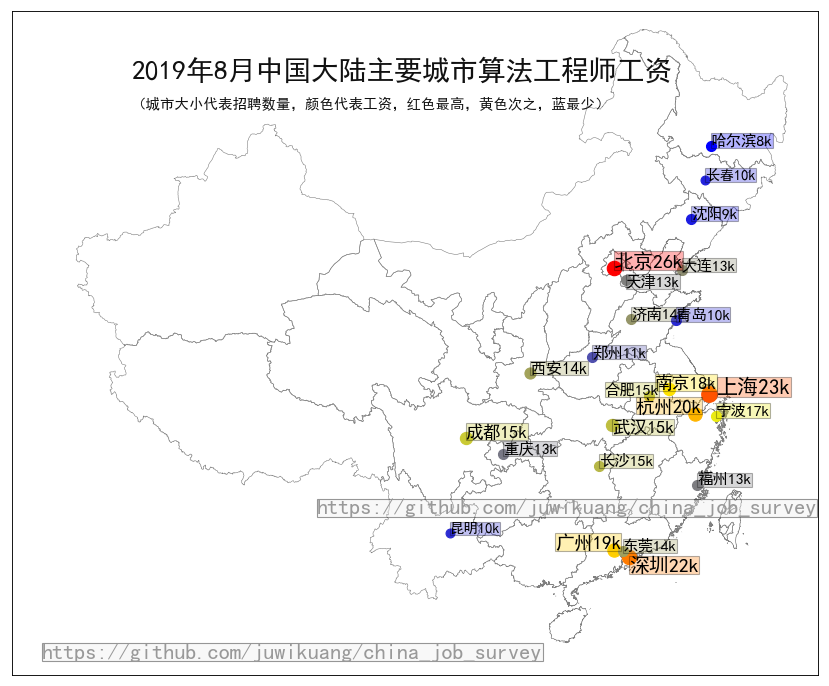

In [38]:
draw_map(data_city_algorithm,100,f'{year}年{month}月中国大陆主要城市算法工程师工资')

# 系统架构师

In [39]:
data_city_architect=get_sub_stats_by_col(data[data.career=='系统架构师'],'city')
data_city_architect.style.format(data_format)

,city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
8,北京,30296,5044,30000,60000,1285,13.36%
7,深圳,26853,5561,25000,60000,1359,14.13%
4,上海,24626,7000,22500,50000,2091,21.73%
20,天津,23462,5425,20667,67200,72,0.75%
5,杭州,23208,4207,22500,45000,527,5.48%
2,南京,20509,6750,20000,37500,450,4.68%
3,广州,19811,5053,19000,45000,1452,15.09%
0,大连,19511,9000,17500,32833,132,1.37%
11,成都,19214,5250,17500,45000,339,3.52%
9,东莞,18507,7000,20000,35000,120,1.25%


In [40]:
describe(data_city_architect,'系统架构师')

2019年8月北京招收系统架构师1285人。2019年8月北京系统架构师平均工资30296元，工资中位数30000元，其中95%的人的工资介于5044元到60000元。

2019年8月深圳招收系统架构师1359人。2019年8月深圳系统架构师平均工资26853元，工资中位数25000元，其中95%的人的工资介于5561元到60000元。

2019年8月上海招收系统架构师2091人。2019年8月上海系统架构师平均工资24626元，工资中位数22500元，其中95%的人的工资介于7000元到50000元。

2019年8月天津招收系统架构师72人。2019年8月天津系统架构师平均工资23462元，工资中位数20667元，其中95%的人的工资介于5425元到67200元。

2019年8月杭州招收系统架构师527人。2019年8月杭州系统架构师平均工资23208元，工资中位数22500元，其中95%的人的工资介于4207元到45000元。

2019年8月南京招收系统架构师450人。2019年8月南京系统架构师平均工资20509元，工资中位数20000元，其中95%的人的工资介于6750元到37500元。

2019年8月广州招收系统架构师1452人。2019年8月广州系统架构师平均工资19811元，工资中位数19000元，其中95%的人的工资介于5053元到45000元。

2019年8月大连招收系统架构师132人。2019年8月大连系统架构师平均工资19511元，工资中位数17500元，其中95%的人的工资介于9000元到32833元。

2019年8月成都招收系统架构师339人。2019年8月成都系统架构师平均工资19214元，工资中位数17500元，其中95%的人的工资介于5250元到45000元。

2019年8月东莞招收系统架构师120人。2019年8月东莞系统架构师平均工资18507元，工资中位数20000元，其中95%的人的工资介于7000元到35000元。

2019年8月西安招收系统架构师235人。2019年8月西安系统架构师平均工资17383元，工资中位数17500元，其中95%的人的工资介于6727元到37187元。

2019年8月武汉招收系统架构师474人。2019年8月武汉系统架构师平均工资16776元，工资中位数15666元，其中95

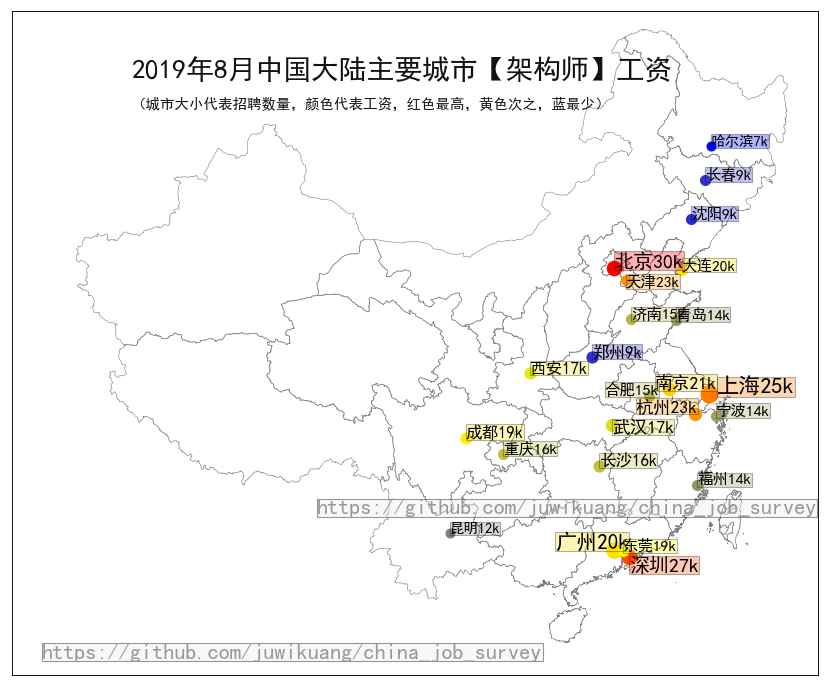

In [41]:
draw_map(data_city_architect,40,f'{year}年{month}月中国大陆主要城市【架构师】工资')

# 生物信息工程师

In [42]:
data_bio=get_sub_stats_by_col(data[data.career=='生物信息工程师'],'city')
data_bio.style.format(data_format)

,city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
0,北京,12500,12500,12500,12500,2,7.14%
4,杭州,12000,11500,12000,12500,2,7.14%
6,长春,11500,11500,11500,11500,2,7.14%
1,广州,11375,7000,11375,14000,8,28.57%
5,上海,9800,8000,9800,12500,5,17.86%
3,武汉,9000,9000,9000,9000,1,3.57%
7,南京,9000,9000,9000,9000,3,10.71%
2,深圳,7500,7500,7500,7500,5,17.86%


In [43]:
describe(data_bio,'生物信息工程师')

2019年8月北京招收生物信息工程师2人。2019年8月北京生物信息工程师平均工资12500元，工资中位数12500元，其中95%的人的工资介于12500元到12500元。

2019年8月杭州招收生物信息工程师2人。2019年8月杭州生物信息工程师平均工资12000元，工资中位数12000元，其中95%的人的工资介于11500元到12500元。

2019年8月长春招收生物信息工程师2人。2019年8月长春生物信息工程师平均工资11500元，工资中位数11500元，其中95%的人的工资介于11500元到11500元。

2019年8月广州招收生物信息工程师8人。2019年8月广州生物信息工程师平均工资11375元，工资中位数11375元，其中95%的人的工资介于7000元到14000元。

2019年8月上海招收生物信息工程师5人。2019年8月上海生物信息工程师平均工资9800元，工资中位数9800元，其中95%的人的工资介于8000元到12500元。

2019年8月武汉招收生物信息工程师1人。2019年8月武汉生物信息工程师平均工资9000元，工资中位数9000元，其中95%的人的工资介于9000元到9000元。

2019年8月南京招收生物信息工程师3人。2019年8月南京生物信息工程师平均工资9000元，工资中位数9000元，其中95%的人的工资介于9000元到9000元。

2019年8月深圳招收生物信息工程师5人。2019年8月深圳生物信息工程师平均工资7500元，工资中位数7500元，其中95%的人的工资介于7500元到7500元。



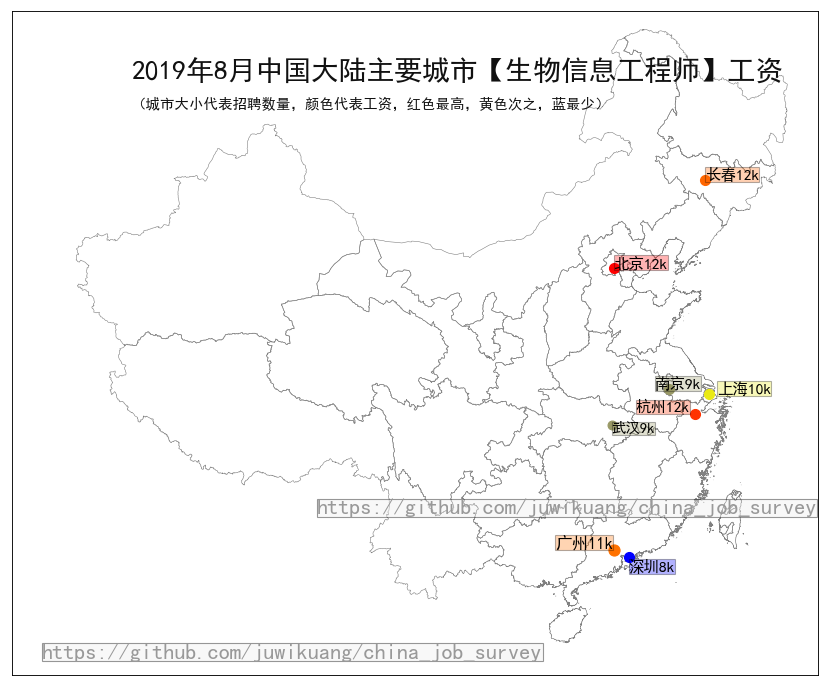

In [44]:
draw_map(data_bio,2,f'{year}年{month}月中国大陆主要城市【生物信息工程师】工资')

# 爬虫工程师

In [45]:
data_spider=get_sub_stats_by_col(data[data.career=='爬虫工程师'],'city')
data_spider=data_spider[data_spider.head_count>10]
data_spider.style.format(data_format)

,city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
7,北京,15604,2050,12500,36917,48,12.44%
1,广州,15455,2500,12214,37500,44,11.40%
12,南京,14861,12500,12833,20000,18,4.66%
5,杭州,14000,11500,12500,22500,12,3.11%
3,上海,13595,5027,12500,28906,105,27.20%
2,深圳,10993,5250,10499,22050,69,17.88%
0,武汉,10872,8000,11625,12500,17,4.40%
8,长沙,10222,9000,10125,11500,18,4.66%
6,成都,6750,2250,5906,14000,20,5.18%
9,郑州,6000,5000,5250,9000,14,3.63%


In [46]:
describe(data_spider, '爬虫工程师')

2019年8月北京招收爬虫工程师48人。2019年8月北京爬虫工程师平均工资15604元，工资中位数12500元，其中95%的人的工资介于2050元到36917元。

2019年8月广州招收爬虫工程师44人。2019年8月广州爬虫工程师平均工资15455元，工资中位数12214元，其中95%的人的工资介于2500元到37500元。

2019年8月南京招收爬虫工程师18人。2019年8月南京爬虫工程师平均工资14861元，工资中位数12833元，其中95%的人的工资介于12500元到20000元。

2019年8月杭州招收爬虫工程师12人。2019年8月杭州爬虫工程师平均工资14000元，工资中位数12500元，其中95%的人的工资介于11500元到22500元。

2019年8月上海招收爬虫工程师105人。2019年8月上海爬虫工程师平均工资13595元，工资中位数12500元，其中95%的人的工资介于5027元到28906元。

2019年8月深圳招收爬虫工程师69人。2019年8月深圳爬虫工程师平均工资10993元，工资中位数10499元，其中95%的人的工资介于5250元到22050元。

2019年8月武汉招收爬虫工程师17人。2019年8月武汉爬虫工程师平均工资10872元，工资中位数11625元，其中95%的人的工资介于8000元到12500元。

2019年8月长沙招收爬虫工程师18人。2019年8月长沙爬虫工程师平均工资10222元，工资中位数10125元，其中95%的人的工资介于9000元到11500元。

2019年8月成都招收爬虫工程师20人。2019年8月成都爬虫工程师平均工资6750元，工资中位数5906元，其中95%的人的工资介于2250元到14000元。

2019年8月郑州招收爬虫工程师14人。2019年8月郑州爬虫工程师平均工资6000元，工资中位数5250元，其中95%的人的工资介于5000元到9000元。



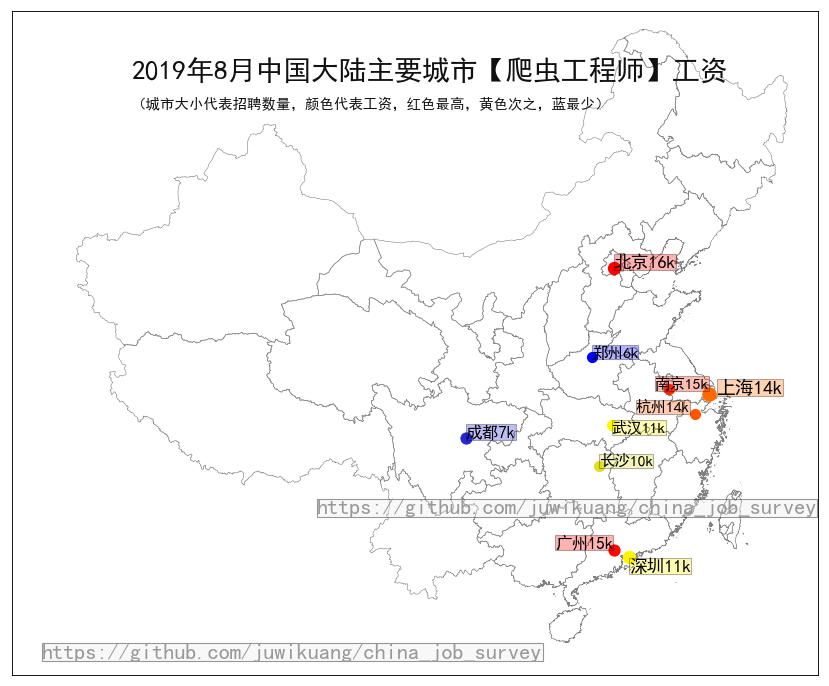

In [47]:
draw_map(data_spider,5,f'{year}年{month}月中国大陆主要城市【爬虫工程师】工资')

# Java程序员

In [48]:
data_java=get_sub_stats_by_col(data[(data.pl_java==1)],'city')
data_java.style.format(data_format)

,city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
4,上海,16817,5250,15000,35000,21235,17.33%
7,深圳,16577,6519,15000,37500,16792,13.71%
3,北京,16532,3750,13833,40000,13547,11.06%
1,杭州,15485,3661,14000,35000,6909,5.64%
2,广州,13730,3750,12500,30000,14330,11.70%
6,南京,13155,4450,12500,25000,8168,6.67%
16,东莞,12098,3403,12500,25000,1069,0.87%
5,成都,11837,3000,11500,25542,5075,4.14%
0,武汉,11277,5000,10500,25000,6061,4.95%
8,大连,10978,2500,9000,30000,5874,4.79%


In [49]:
describe(data_java, 'Java程序员')

2019年8月上海招收Java程序员21235人。2019年8月上海Java程序员平均工资16817元，工资中位数15000元，其中95%的人的工资介于5250元到35000元。

2019年8月深圳招收Java程序员16792人。2019年8月深圳Java程序员平均工资16577元，工资中位数15000元，其中95%的人的工资介于6519元到37500元。

2019年8月北京招收Java程序员13547人。2019年8月北京Java程序员平均工资16532元，工资中位数13833元，其中95%的人的工资介于3750元到40000元。

2019年8月杭州招收Java程序员6909人。2019年8月杭州Java程序员平均工资15485元，工资中位数14000元，其中95%的人的工资介于3661元到35000元。

2019年8月广州招收Java程序员14330人。2019年8月广州Java程序员平均工资13730元，工资中位数12500元，其中95%的人的工资介于3750元到30000元。

2019年8月南京招收Java程序员8168人。2019年8月南京Java程序员平均工资13155元，工资中位数12500元，其中95%的人的工资介于4450元到25000元。

2019年8月东莞招收Java程序员1069人。2019年8月东莞Java程序员平均工资12098元，工资中位数12500元，其中95%的人的工资介于3403元到25000元。

2019年8月成都招收Java程序员5075人。2019年8月成都Java程序员平均工资11837元，工资中位数11500元，其中95%的人的工资介于3000元到25542元。

2019年8月武汉招收Java程序员6061人。2019年8月武汉Java程序员平均工资11277元，工资中位数10500元，其中95%的人的工资介于5000元到25000元。

2019年8月大连招收Java程序员5874人。2019年8月大连Java程序员平均工资10978元，工资中位数9000元，其中95%的人的工资介于2500元到30000元。

2019年8月西安招收Java程序员3348人。2019年8月西安Java程序员平均工资10838元，工资中位数10499元，其中95%的人的工资介于3000元到22500元。

2019年8月

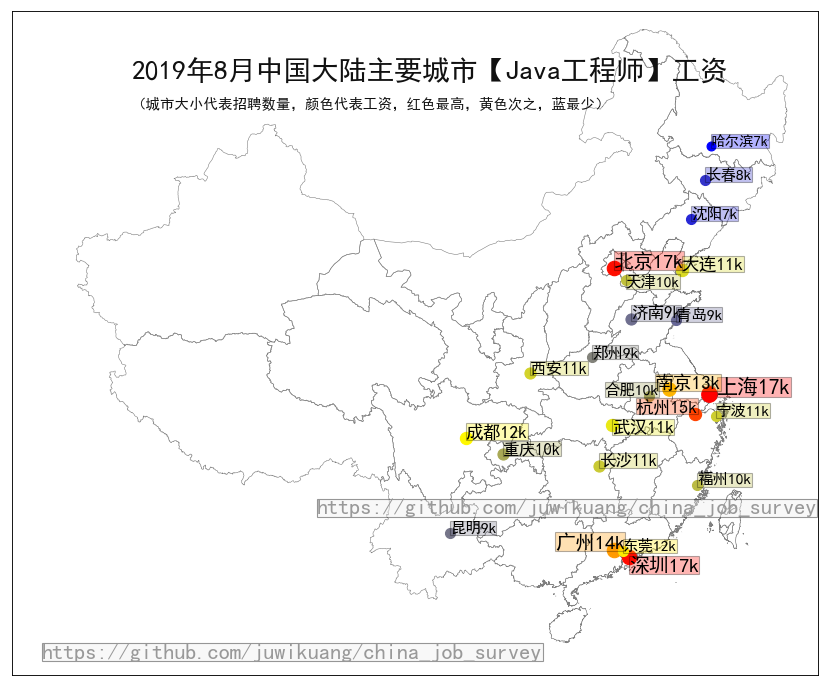

In [50]:
draw_map(data_java, 500, f'{year}年{month}月中国大陆主要城市【Java工程师】工资')

# Python程序员

In [51]:
data_python=get_sub_stats_by_col(data[(data.pl_python==1)],'city')

data_python.style.format(data_format)

,city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
7,北京,22512,3959,20000,55000,4467,15.39%
4,上海,21241,5272,20000,45833,6579,22.66%
6,深圳,20653,6500,17500,45000,3928,13.53%
2,杭州,17552,3614,15000,45000,1693,5.83%
0,广州,17247,4282,15499,40000,3039,10.47%
9,南京,16443,3929,15000,35000,2002,6.90%
11,天津,15690,6500,18500,22500,355,1.22%
10,成都,15637,3605,14000,35000,1342,4.62%
20,宁波,14690,3148,10416,51722,134,0.46%
13,大连,14624,2500,11917,48413,566,1.95%


In [52]:
describe(data_python, 'Python程序员')

2019年8月北京招收Python程序员4467人。2019年8月北京Python程序员平均工资22512元，工资中位数20000元，其中95%的人的工资介于3959元到55000元。

2019年8月上海招收Python程序员6579人。2019年8月上海Python程序员平均工资21241元，工资中位数20000元，其中95%的人的工资介于5272元到45833元。

2019年8月深圳招收Python程序员3928人。2019年8月深圳Python程序员平均工资20653元，工资中位数17500元，其中95%的人的工资介于6500元到45000元。

2019年8月杭州招收Python程序员1693人。2019年8月杭州Python程序员平均工资17552元，工资中位数15000元，其中95%的人的工资介于3614元到45000元。

2019年8月广州招收Python程序员3039人。2019年8月广州Python程序员平均工资17247元，工资中位数15499元，其中95%的人的工资介于4282元到40000元。

2019年8月南京招收Python程序员2002人。2019年8月南京Python程序员平均工资16443元，工资中位数15000元，其中95%的人的工资介于3929元到35000元。

2019年8月天津招收Python程序员355人。2019年8月天津Python程序员平均工资15690元，工资中位数18500元，其中95%的人的工资介于6500元到22500元。

2019年8月成都招收Python程序员1342人。2019年8月成都Python程序员平均工资15637元，工资中位数14000元，其中95%的人的工资介于3605元到35000元。

2019年8月宁波招收Python程序员134人。2019年8月宁波Python程序员平均工资14690元，工资中位数10416元，其中95%的人的工资介于3148元到51722元。

2019年8月大连招收Python程序员566人。2019年8月大连Python程序员平均工资14624元，工资中位数11917元，其中95%的人的工资介于2500元到48413元。

2019年8月武汉招收Python程序员1389人。2019年8月武汉Python程序员平均工资14566元，工资中位数130

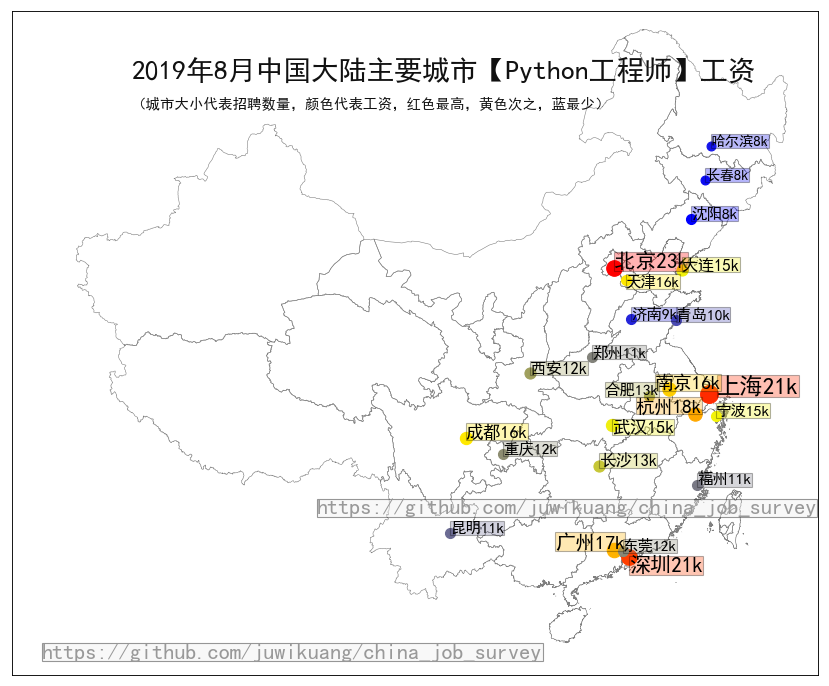

In [53]:
draw_map(data_python, 100,  f'{year}年{month}月中国大陆主要城市【Python工程师】工资')